In [1]:
import aesara.tensor as aet
import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
import xarray
from scipy.special import expit as logistic

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3


In [2]:
arviz.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
np.random.seed(286)

## Data

In [4]:
results_by_regions = pd.read_csv(
    "https://raw.githubusercontent.com/pollsposition/data/main/results_by_regions.csv"
)
subset = (
    results_by_regions[results_by_regions.type.isin(["president", "european"])]
    .reset_index(drop=True)
    .set_index(["election_day", "region"])
)
subset

,election_day,type,region,N,farleft,left,green,center,right,farright,other
0,2002-04-21,president,Auvergne-Rhône-Alpes,3321976,323854,472029,191041,253051,597258,620297,864446
1,2002-04-21,president,Bourgogne-Franche-Comté,1377707,142423,207869,63466,87840,254522,261422,360165
2,2002-04-21,president,Bretagne,1585745,189416,286515,102128,113920,342538,187323,363905
3,2002-04-21,president,Centre-Val de Loire,1221727,125029,184174,55098,82415,244240,210385,320386
4,2002-04-21,president,Corse,109462,6629,16836,3265,3660,30180,17166,31726
...,...,...,...,...,...,...,...,...,...,...,...
135,2019-05-26,european,Normandie,1211420,75665,71759,137325,253703,95280,322381,255307
136,2019-05-26,european,Nouvelle-Aquitaine,2222990,156342,172774,295549,495592,166505,496762,439466
137,2019-05-26,european,Occitanie,2186389,162093,165841,288703,439620,153909,562721,413502
138,2019-05-26,european,Pays de la Loire,1342007,71373,93308,209027,337679,117138,252548,260934


In [6]:
# small data sanity check
raw_N = subset[COORDS["parties_complete"]].sum(1)
subset["N"].equals(raw_N)

In [11]:
# second sanity check
subset[subset.isna().any(axis=1)]

,,type,N,farleft,left,green,center,right,farright,other
election_day,region,,,,,,,,,


In [9]:
# prevents overflow issue
# TODO: stats consequences?
subset[COORDS["parties_complete"]] = subset[COORDS["parties_complete"]] // 100

In [109]:
COORDS = {
    "parties": ["farleft", "left", "green", "center", "right", "farright"],
    "parties_complete": [
        "farleft",
        "left",
        "green",
        "center",
        "right",
        "farright",
        "other",
    ],
    "observations": subset.index,
}

## Simplest fundamentals model

In [42]:
with pm.Model(coords=COORDS) as m_real:
    n_cutpoints = len(COORDS["parties"])
    cut_base = pm.Normal("cut_base", mu=-1, sigma=3)
    cut_diffs = pm.HalfNormal("cut_diffs", sigma=2 / n_cutpoints, shape=n_cutpoints - 1)

    cutpoints = pm.Deterministic(
        "cutpoints",
        aet.concatenate([[cut_base], cut_base + cut_diffs.cumsum()]),
        dims="parties",
    )

    # cutpoints = pm.Normal(
    #   "cutpoints",
    #  mu=np.arange(6) - 2.5,
    # sigma=1.5,
    # initval=np.arange(6) - 2.5,
    # transform=pm.distributions.transforms.ordered,
    # dims="parties",
    # )

    pm.OrderedMultinomial(
        "results",
        eta=0,
        cutpoints=cutpoints,
        n=subset[COORDS["parties_complete"]].sum(1).values,
        observed=subset[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    trace = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs=dict(
            dims={"results_probs": ["parties_complete"]},
            coords={
                "parties_complete": COORDS["parties_complete"],
            },
        ),
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cut_base, cut_diffs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


0, dim: observations, 140 =? 140


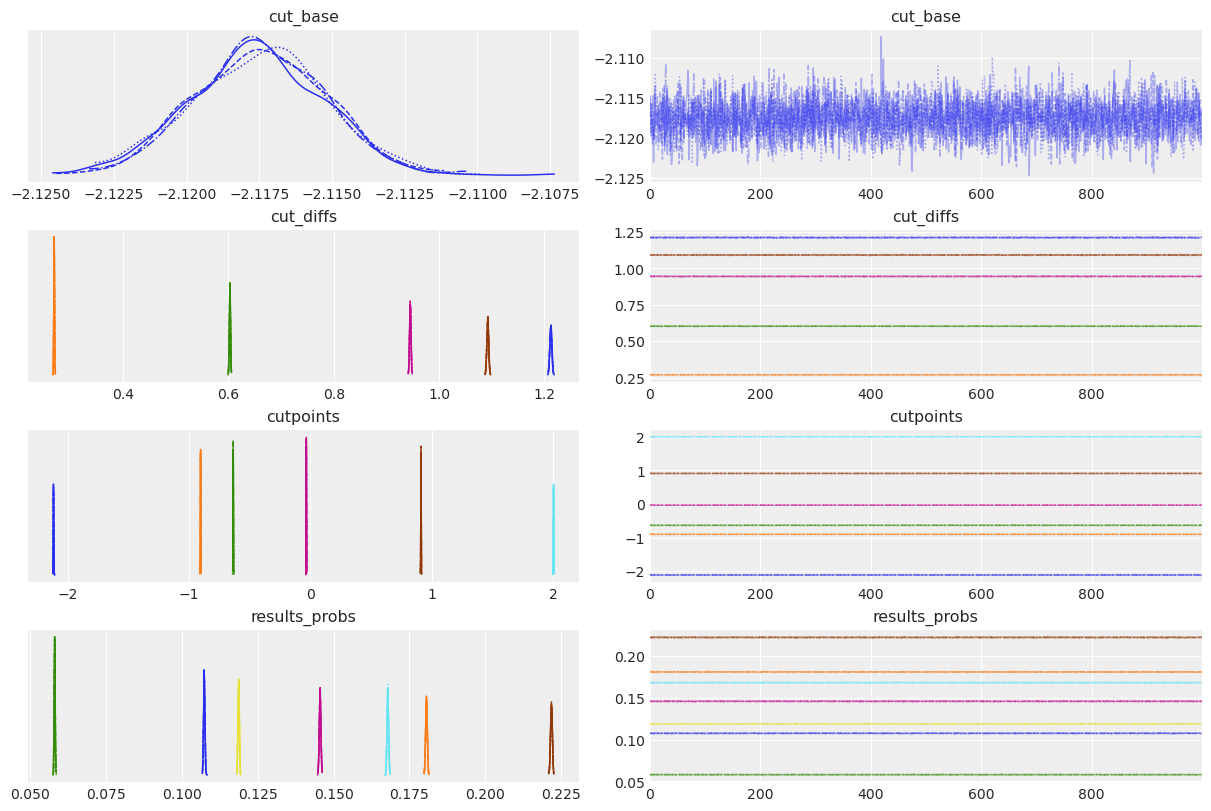

In [44]:
arviz.plot_trace(trace);

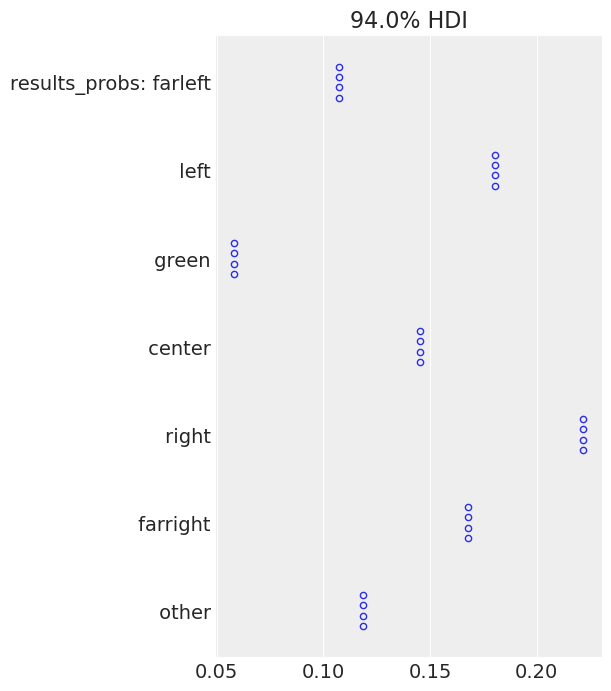

In [46]:
arviz.plot_forest(trace, var_names="results_probs");

## Regional fundamentals model

In [111]:
region_idx, COORDS["regions"] = pd.factorize(
    subset.index.get_level_values("region"), sort=True
)

In [80]:
with pm.Model(coords=COORDS) as m_real:

    initval = np.tile(
        np.arange(len(COORDS["parties"])) - 2.5, reps=(len(COORDS["regions"]), 1)
    )
    cutpoints = pm.Normal(
        "cutpoints",
        mu=initval,
        sigma=3.0,
        initval=initval,
        transform=pm.distributions.transforms.ordered,
        dims=("regions", "parties"),
    )

    pm.OrderedMultinomial(
        "results",
        eta=0,
        cutpoints=cutpoints[region_idx],
        n=subset[COORDS["parties_complete"]].sum(1).values,
        observed=subset[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    trace = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs=dict(
            dims={"results_probs": ["observations", "parties_complete"]},
            # coords={
            #   "parties_complete": COORDS["parties_complete"],
            # }
        ),
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[18  6]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


0, dim: observations, 140 =? 140


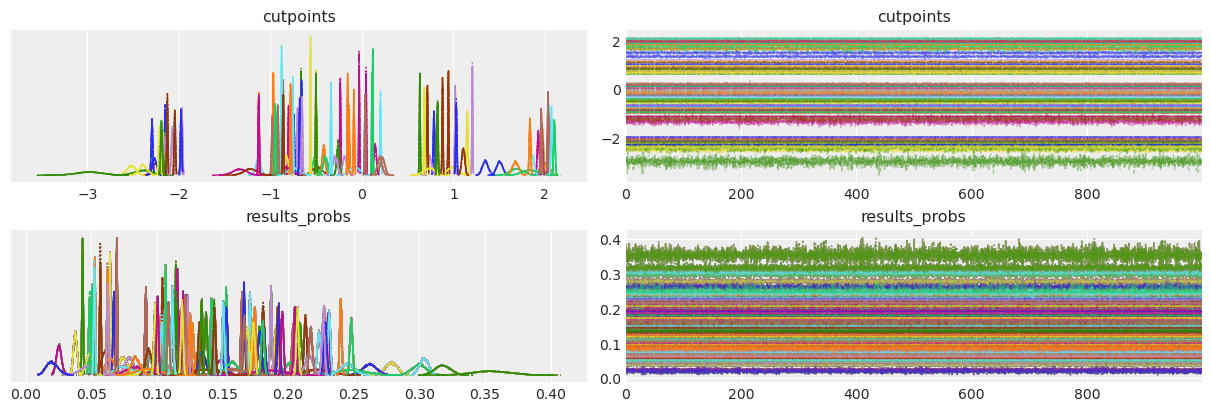

In [82]:
arviz.plot_trace(trace);

## Hierarchical simple fundamentals model

In [112]:
with pm.Model(coords=COORDS) as m_real:

    init_mean = np.arange(len(COORDS["parties"])) - 2.5
    mean = pm.Normal(
        "cutpoint_mean",
        mu=init_mean,
        sigma=3.0,
        initval=init_mean,
        transform=pm.distributions.transforms.ordered,
        dims="parties",
    )
    sd = pm.HalfNormal("cutpoint_sd")

    init_cut=np.tile(
            np.arange(len(COORDS["parties"])) - 2.5, reps=(len(COORDS["regions"]), 1)
        )
    cutpoints = pm.Normal(
        "cutpoints",
        mu=mean,
        sigma=sd,
        initval=init_cut,
        transform=pm.distributions.transforms.ordered,
        dims=("regions", "parties"),
    )

    pm.OrderedMultinomial(
        "results",
        eta=0,
        cutpoints=cutpoints[region_idx],
        n=subset[COORDS["parties_complete"]].sum(1).values,
        observed=subset[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    trace = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs=dict(
            dims={"results_probs": ["observations", "parties_complete"]},
        ),
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoint_mean, cutpoint_sd, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.


0, dim: observations, 140 =? 140


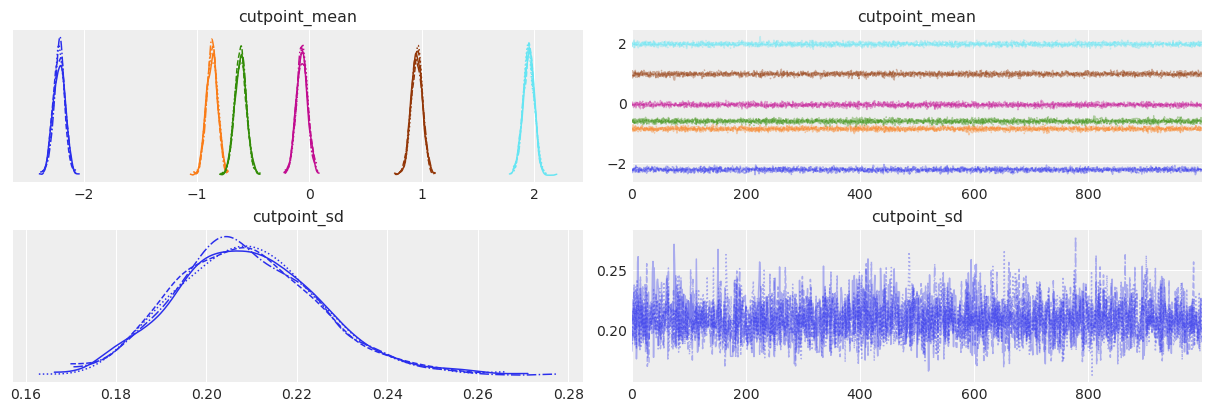

In [96]:
arviz.plot_trace(trace, var_names="cutpoint_", filter_vars="like");

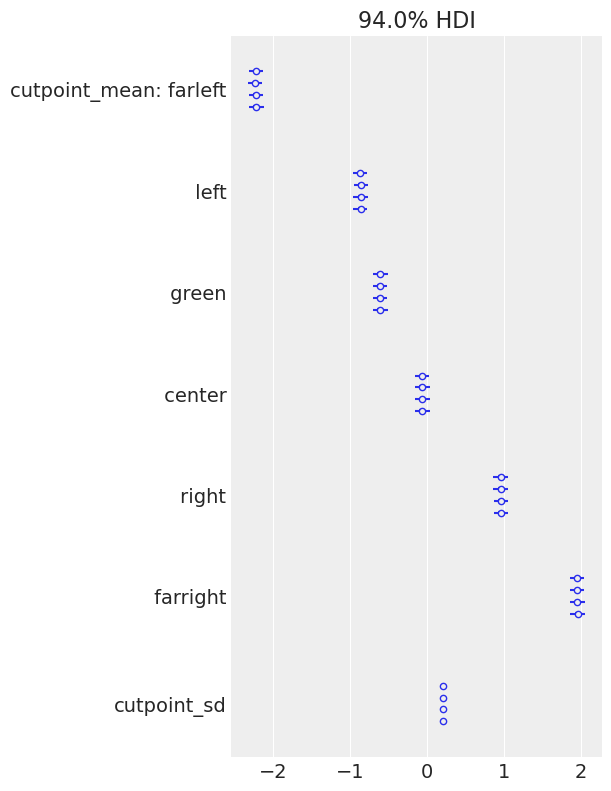

In [97]:
arviz.plot_forest(trace, var_names="cutpoint_", filter_vars="like");

In [118]:
p_cum = logistic(trace.posterior.cutpoints)

In [ ]:
true_p = np.hstack([true_cum_p[0], true_cum_p[1:] - true_cum_p[:-1]])

In [146]:
np.concatenate([p_cum.data[..., 0], p_cum.data[..., 1:] - p_cum.data[..., :-1]])

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)

In [145]:
p_cum.data[..., 0].
np.

(4, 1000, 18)

In [ ]:

p_cum = at.concatenate(
    [
        at.zeros_like(aet.shape_padright(pa[..., 0])),
        pa,
        at.ones_like(at.shape_padright(pa[..., 0])),
    ],
    axis=-1,
)
p = p_cum[..., 1:] - p_cum[..., :-1]

#### Code 12.24

In [32]:
R = trolley_df.response.values - 1

with pm.Model() as m12_5:
    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,
    )
    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bIA = pm.Normal("bIA", 0.0, 0.5)
    bIC = pm.Normal("bIC", 0.0, 0.5)

    A = pm.Data("A", trolley_df.action.values)
    I = pm.Data("I", trolley_df.intention.values)
    C = pm.Data("C", trolley_df.contact.values)

    BI = bI + bIA * A + bIC * C
    phi = pm.Deterministic("phi", bA * A + bC * C + BI * I)

    resp_obs = pm.OrderedLogistic("resp_obs", phi, cutpoints, observed=R)

    trace_12_5 = pm.sample(random_seed=RANDOM_SEED)

idata = arviz.from_pymc3(trace_12_5)
arviz.summary(idata, var_names=["bIC", "bIA", "bC", "bI", "bA"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bIC, bIA, bI, bC, bA, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 149 seconds.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bIC,-1.24,0.10,-1.39,-1.08,0.0,0.0,2580.11,2578.04,2586.18,2613.44,1.0
bIA,-0.43,0.08,-0.56,-0.31,0.0,0.0,2181.93,2181.93,2208.31,2787.54,1.0
bC,-0.34,0.07,-0.45,-0.23,0.0,0.0,2365.23,2352.44,2356.89,2724.86,1.0
bI,-0.29,0.06,-0.40,-0.21,0.0,0.0,1801.23,1801.23,1806.47,2388.10,1.0
bA,-0.47,0.05,-0.55,-0.38,0.0,0.0,2344.58,2321.42,2348.69,2861.52,1.0


#### Code 12.25

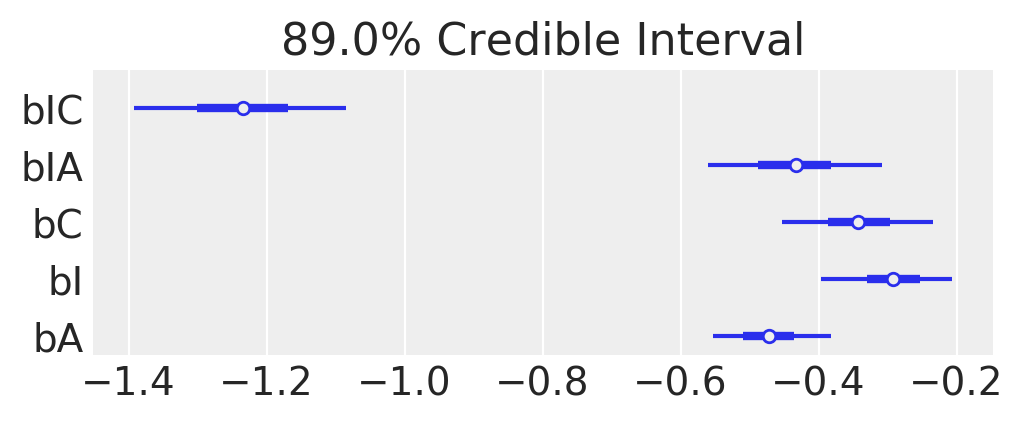

In [33]:
arviz.plot_forest(
    idata, var_names=["bIC", "bIA", "bC", "bI", "bA"], figsize=(5, 2), combined=True
);

#### Code 12.26 - 28

In [34]:
# Observed cum probs:
p_obs = (
    trolley_df.groupby(["action", "contact", "intention"])
    .response.value_counts(normalize=True, sort=False)
    .unstack()
    .cumsum(axis=1)
    .iloc[:, :-1]
)
p_obs.columns = range(6)
p_obs

0         1         2         3         4  \
action contact intention                                                     
0      0       0          0.050755  0.112991  0.187915  0.443505  0.596375   
               1          0.070997  0.155589  0.251259  0.514602  0.652064   
       1       0          0.092649  0.150050  0.249748  0.497482  0.677744   
               1          0.336354  0.497482  0.645519  0.791541  0.880161   
1      0       0          0.100831  0.179003  0.285876  0.535876  0.709215   
               1          0.215106  0.344411  0.482175  0.677946  0.804834   

                                 5  
action contact intention            
0      0       0          0.779456  
               1          0.820242  
       1       0          0.856999  
               1          0.942598  
1      0       0          0.863293  
               1          0.901511

In [35]:
# Counterfactual cases:
cases_df = pd.DataFrame(
    np.array([[0, 0, 0], [0, 0, 1], [1, 0, 0], [1, 0, 1], [0, 1, 0], [0, 1, 1]]),
    columns=["action", "contact", "intention"],
)
cases_df

,action,contact,intention
0,0,0,0
1,0,0,1
2,1,0,0
3,1,0,1
4,0,1,0
5,0,1,1


In [36]:
with m12_5:
    pm.set_data(
        {
            "A": cases_df.action.values,
            "C": cases_df.contact.values,
            "I": cases_df.intention.values,
        }
    )
    pp_phi = pm.sample_posterior_predictive(
        trace_12_5, var_names=["phi"], random_seed=RANDOM_SEED
    )["phi"]

In [37]:
def p_ord_logit(responses: range, phi: np.ndarray, a: np.ndarray):
    """
    For the given posterior sample, computes the cumulative probabilities
    of each response in each of the counterfactual values of the predictors.

    responses: range of possible responses in the experiment
    phi: posterior phi for each counterfactual case
    a: posterior intercept for each response
    """
    p = pd.DataFrame(index=range(len(cases_df)), columns=responses)
    for case in p.index:
        p.loc[case] = logistic(a - phi[case])

    p = (
        pd.concat([cases_df, p], axis=1)
        .set_index(["action", "contact", "intention"])
        .sort_index()
    )
    p.index.name = "case"
    p.columns.name = "response"

    return p

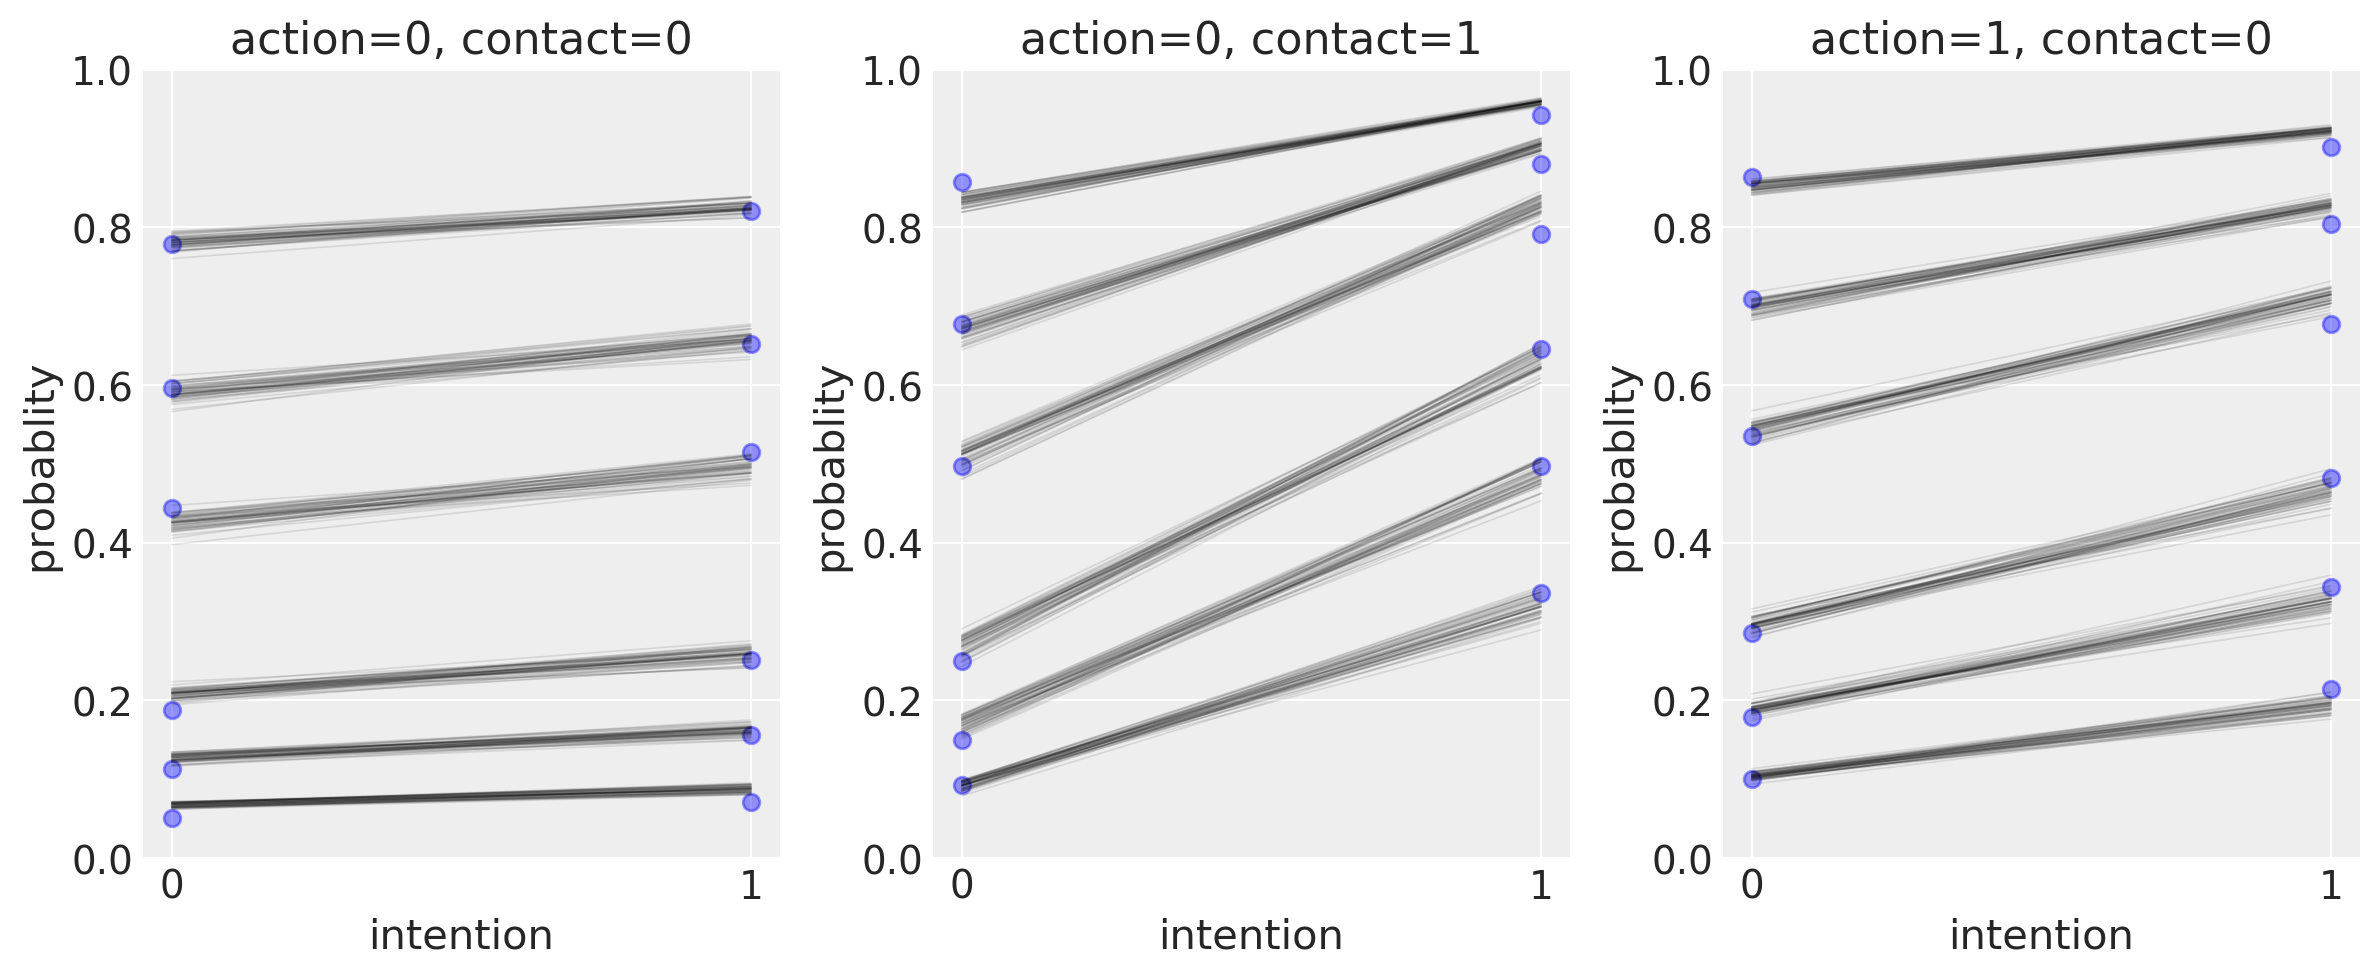

In [38]:
_, axes = plt.subplots(1, 3, figsize=(12, 5))

for s in range(50):
    p = p_ord_logit(responses=range(6), phi=pp_phi[s], a=trace_12_5["cutpoints"][s])

    cur_ax = 0
    for (action, contact), _ in p.groupby(level=["action", "contact"]):
        axes[cur_ax].plot([0, 1], p.loc[action, contact], lw=0.6, c="k", alpha=0.1)

        if s == 0:
            axes[cur_ax].plot([0, 1], p_obs.loc[action, contact], "ob", alpha=0.4)
            axes[cur_ax].set_xticks([0, 1])
            axes[cur_ax].set_xlabel("intention")
            axes[cur_ax].set_ylabel("probablity")
            axes[cur_ax].set_ylim([0, 1])
            axes[cur_ax].set_title(f"action={action}, contact={contact}")

        cur_ax += 1
plt.tight_layout()

#### Code 12.29

In [39]:
with m12_5:
    pp_resp = pm.sample_posterior_predictive(
        trace_12_5, var_names=["resp_obs"], random_seed=RANDOM_SEED
    )["resp_obs"]

resp_df = pd.DataFrame(pp_resp).T
resp_df.index.name = "case"
resp_df = (
    pd.concat([cases_df, resp_df], axis=1)
    .set_index(["action", "contact", "intention"])
    .sort_index()
)
resp_df

0     1     2     3     4     5     6     7     \
action contact intention                                                   
0      0       0             2     4     3     5     2     4     5     3   
               1             3     6     5     1     6     5     6     3   
       1       0             0     1     4     3     2     0     6     4   
               1             0     4     5     5     1     3     6     2   
1      0       0             3     4     1     3     6     2     2     5   
               1             3     3     1     0     4     3     4     5   

                          8     9     ...  3990  3991  3992  3993  3994  3995  \
action contact intention              ...                                       
0      0       0             6     3  ...     0     4     4     2     3     3   
               1             1     3  ...     2     5     6     3     0     0   
       1       0             3     5  ...     0     2     1     3     1     3   
               1             3     3  ...     2     2     3     0     3     3   
1      0       0             6     2  ...     4     5     0     0     3     5   
               1             6     2  ...     5     2     1     6     5     0   

                          3996  3997  3998  3999  
action contact intention                          
0      0       0             5     1     4     3  
               1             1     5     6     6  
       1       0             5     4     2     5  
               1             2     0     0     2  
1      0       0             1     3     3     6  
               1             3     3     4     4  

[6 rows x 4000 columns]

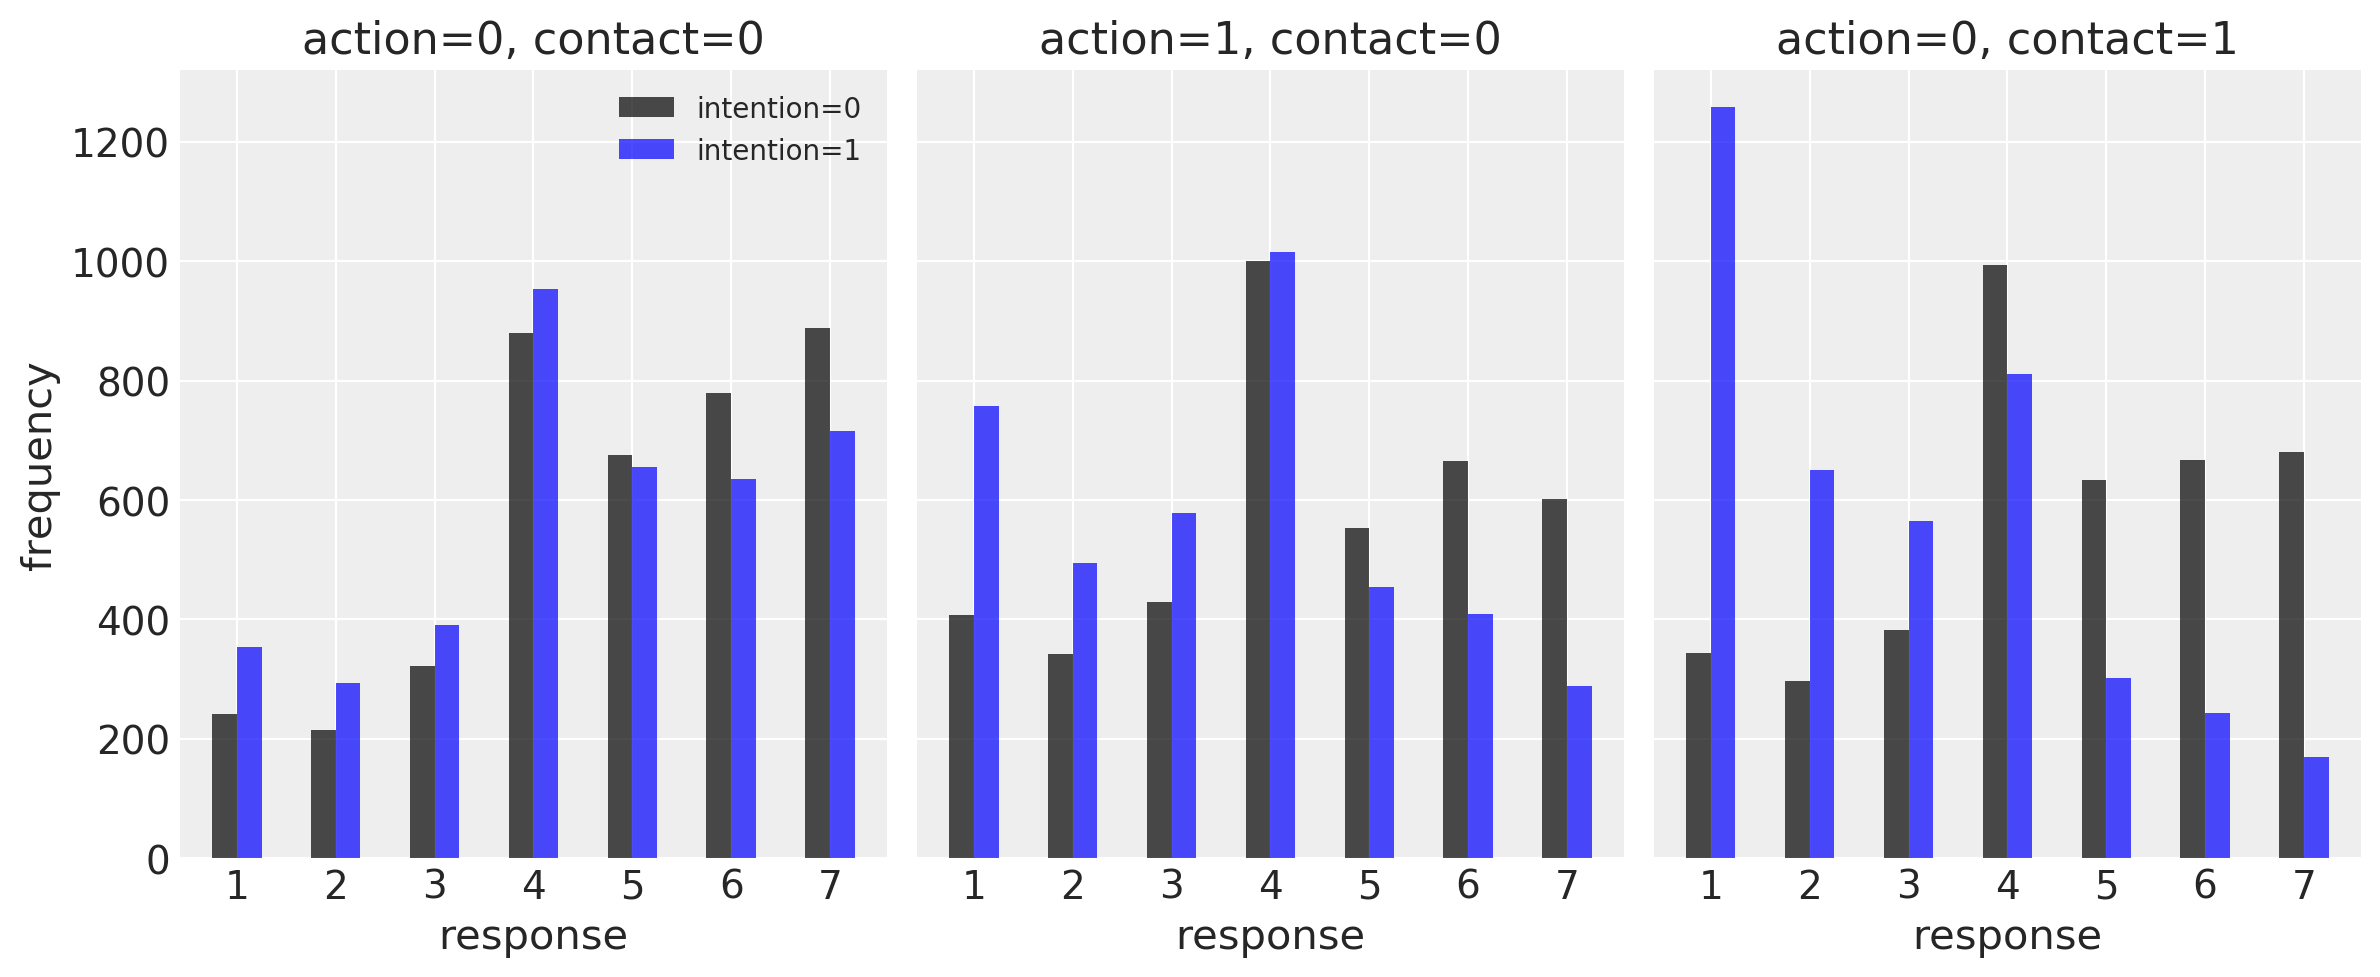

In [40]:
_, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
bins, xticks, xlabels, colors = (
    np.arange(8) - 0.5,
    np.arange(7),
    np.arange(1, 8),
    ["k", "b"],
)

axes[0].hist(
    [resp_df.loc[0, 0, 0], resp_df.loc[0, 0, 1]],
    bins=bins,
    rwidth=0.5,
    label=["intention=0", "intention=1"],
    color=colors,
    alpha=0.7,
)
axes[0].set_title("action=0, contact=0")
axes[0].set_ylabel("frequency")
axes[0].legend(fontsize=10)

axes[1].hist(
    [resp_df.loc[1, 0, 0], resp_df.loc[1, 0, 1]],
    bins=bins,
    rwidth=0.5,
    color=colors,
    alpha=0.7,
)
axes[1].set_title("action=1, contact=0")

axes[2].hist(
    [resp_df.loc[0, 1, 0], resp_df.loc[0, 1, 1]],
    bins=bins,
    rwidth=0.5,
    color=colors,
    alpha=0.7,
)
axes[2].set_title("action=0, contact=1")

for ax in axes:
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)
    ax.set_xlabel("response")
plt.tight_layout();

#### Code 12.30

In [41]:
pd.Categorical(trolley_df.edu)

[Middle School, Middle School, Middle School, Middle School, Middle School, ..., Graduate Degree, Graduate Degree, Graduate Degree, Graduate Degree, Graduate Degree]
Length: 9930
Categories (8, object): [Bachelor's Degree, Elementary School, Graduate Degree, High School Graduate, Master's Degree, Middle School, Some College, Some High School]

#### Code 12.31

In [42]:
trolley_df["edu_new"] = pd.Categorical(
    trolley_df.edu.values,
    categories=[
        "Elementary School",
        "Middle School",
        "Some High School",
        "High School Graduate",
        "Some College",
        "Bachelor's Degree",
        "Master's Degree",
        "Graduate Degree",
    ],
    ordered=True,
)
trolley_df["edu_new"] = trolley_df.edu_new.cat.codes

#### Code 12.32

In [43]:
delta = np.random.dirichlet(np.repeat(2.0, 7), size=10)

#### Code 12.33

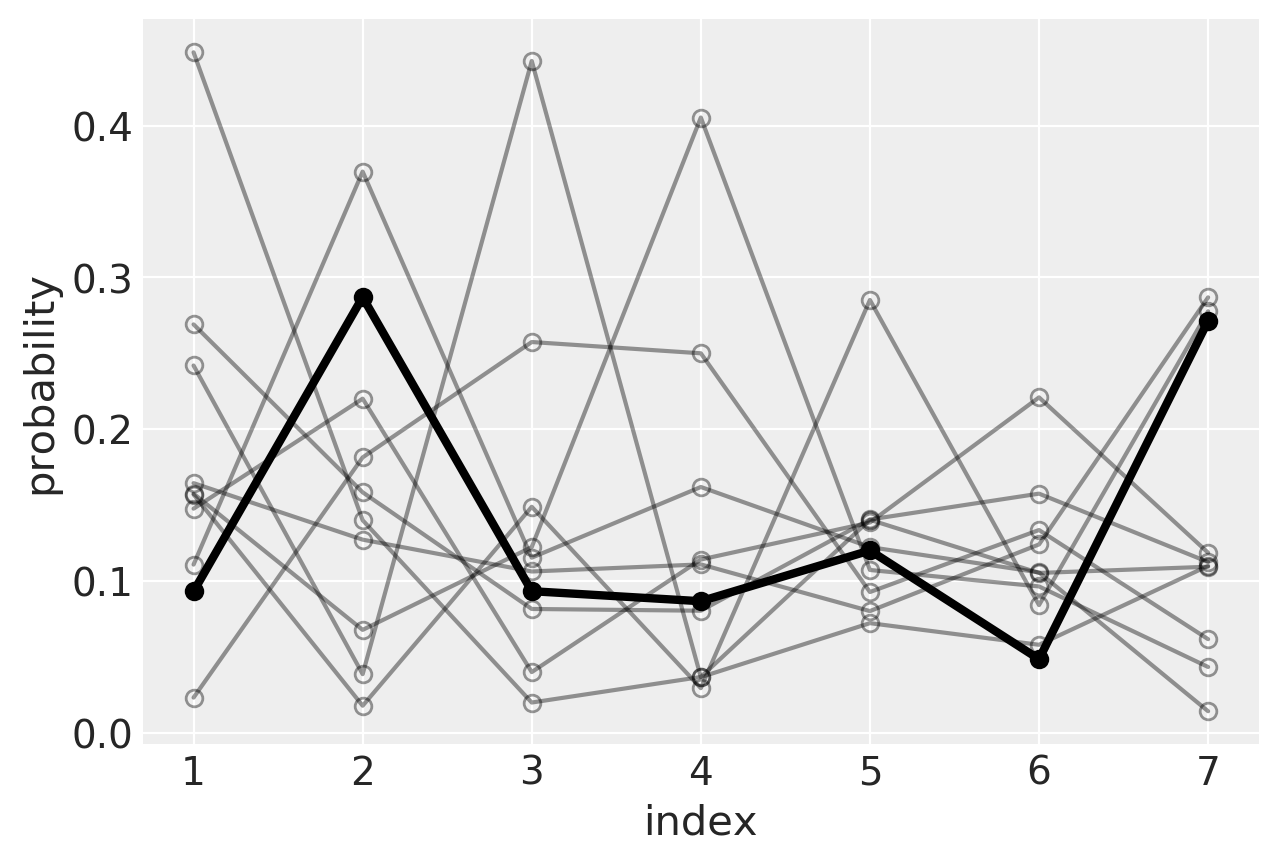

In [44]:
plt.plot(np.stack([range(1, 8)] * 9).T, delta[1:].T, "-ok", alpha=0.4, fillstyle="none")
plt.plot(np.arange(1, 8).T, delta[0].T, "-ok", lw=3, ms=6)
plt.xlabel("index")
plt.ylabel("probability");

#### Code 12.34

In [45]:
R = trolley_df.response.values - 1
A = trolley_df.action.values
I = trolley_df.intention.values
C = trolley_df.contact.values
E = trolley_df.edu_new.values

with pm.Model() as m12_6:
    kappa = pm.Normal(
        "kappa",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6),
    )

    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bE = pm.Normal("bE", 0.0, 0.5)

    delta = pm.Dirichlet("delta", np.repeat(2.0, 7), shape=7)
    delta_j = tt.concatenate([tt.zeros(1), delta])
    delta_j_cumulative = tt.cumsum(delta_j)

    phi = bE * delta_j_cumulative[E] + bA * A + bC * C + bI * I

    resp_obs = pm.OrderedLogistic("resp_obs", phi, kappa, observed=R)

    trace_12_6 = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, bE, bI, bC, bA, kappa]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 684 seconds.


#### Code 12.35

In [46]:
idata = arviz.from_pymc3(trace_12_6)
arviz.summary(idata, var_names=["bA", "bC", "bI", "bE", "delta"], round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bA,-0.70,0.04,-0.76,-0.63,0.0,0.0,9990.07,9990.07,9996.00,6551.61,1.0
bC,-0.95,0.05,-1.03,-0.87,0.0,0.0,9662.57,9628.85,9608.61,6297.14,1.0
bI,-0.71,0.04,-0.77,-0.66,0.0,0.0,10984.65,10980.29,10981.35,5893.35,1.0
bE,-0.29,0.16,-0.53,-0.04,0.0,0.0,3556.16,3451.83,3661.88,3678.18,1.0
delta[0],0.21,0.13,0.02,0.40,0.0,0.0,6237.78,5570.89,6309.34,5257.06,1.0
delta[1],0.14,0.09,0.01,0.26,0.0,0.0,14485.70,10636.60,12580.66,5153.32,1.0
delta[2],0.19,0.11,0.03,0.35,0.0,0.0,9506.63,8107.80,9029.95,5288.65,1.0
delta[3],0.17,0.10,0.02,0.31,0.0,0.0,9200.11,8075.14,8732.47,5365.69,1.0
delta[4],0.05,0.06,0.00,0.09,0.0,0.0,3083.43,3019.01,5306.42,3598.30,1.0
delta[5],0.10,0.07,0.01,0.19,0.0,0.0,10134.83,8081.59,9728.20,4802.66,1.0


#### Code 12.36

/Users/alex_andorra/opt/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/plots/pairplot.py:167: UserWarning: fill_last and contour will be deprecated. Please use kde_kwargs
  "fill_last and contour will be deprecated. Please use kde_kwargs", UserWarning,


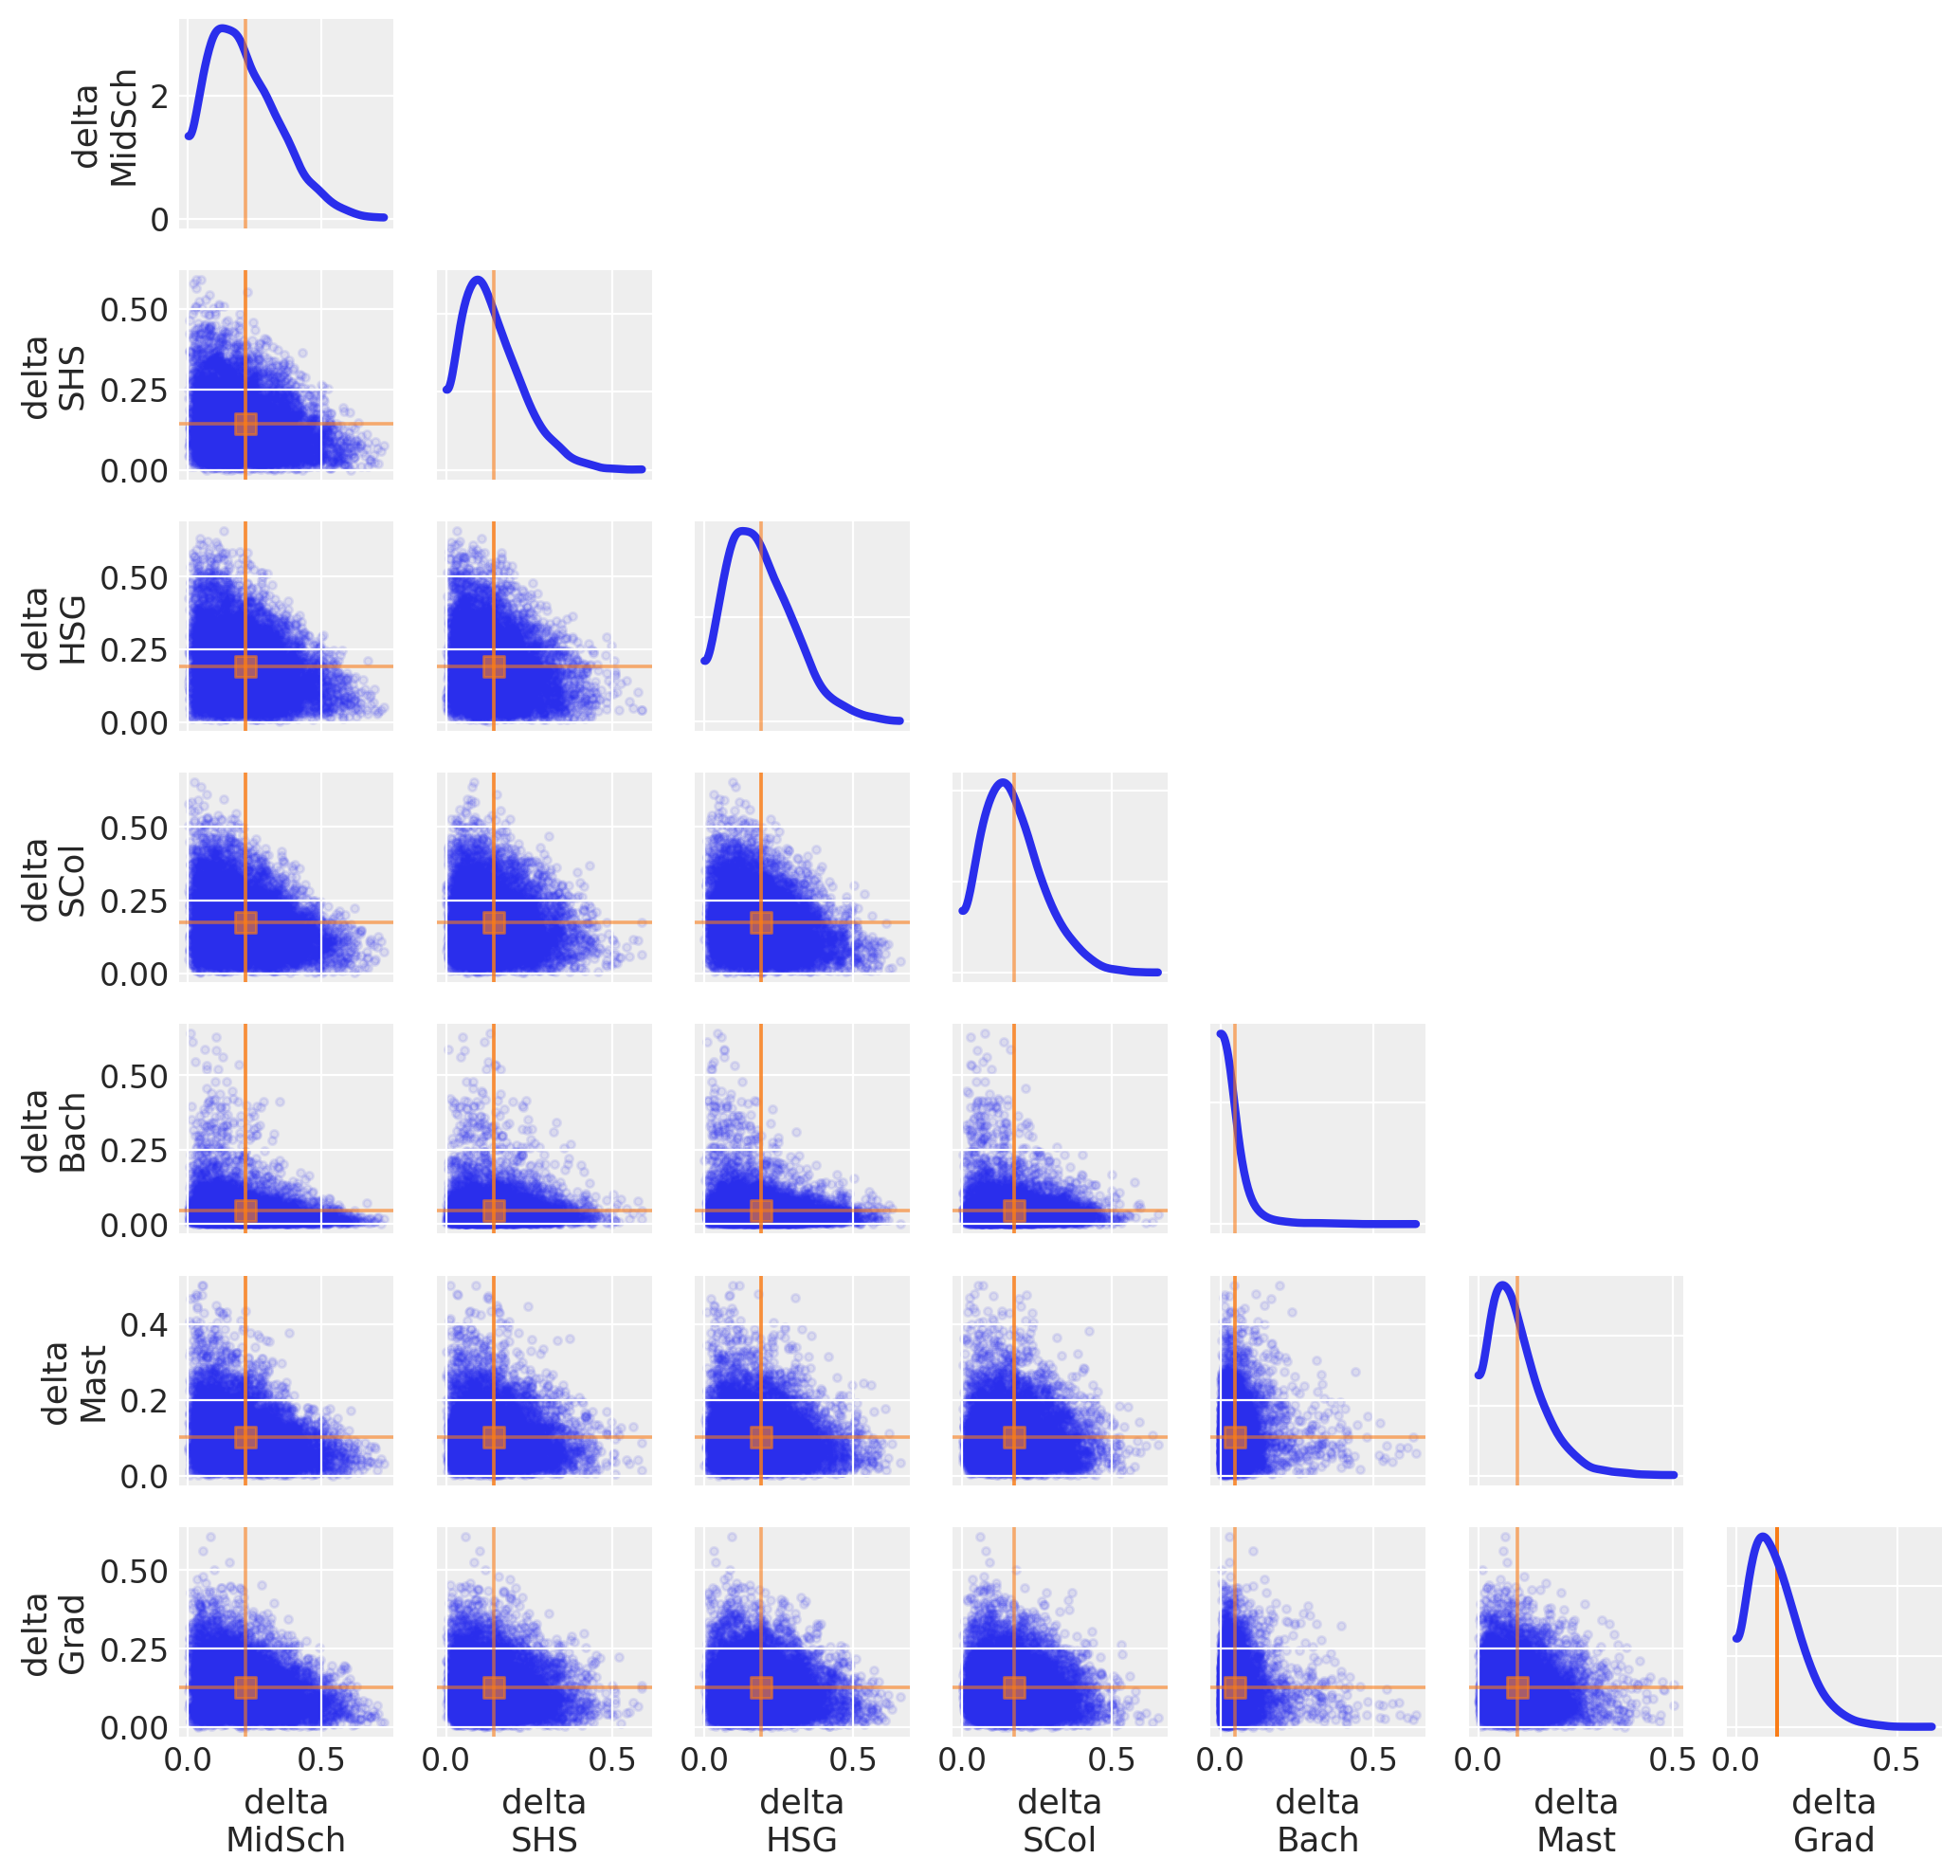

In [47]:
idata.posterior.coords["delta_dim_0"] = [
    "MidSch",
    "SHS",
    "HSG",
    "SCol",
    "Bach",
    "Mast",
    "Grad",
]

arviz.plot_pair(
    idata,
    var_names=["delta"],
    diagonal=True,
    point_estimate="mean",
    textsize=12,
    figsize=(12, 12),
    scatter_kwargs={"alpha": 0.1},
    point_estimate_kwargs={"alpha": 0.6, "lw": 1.3},
    point_estimate_marker_kwargs={"alpha": 0.6},
);

#### Code 12.37

In [48]:
edu_norm = (
    (trolley_df.edu_new - trolley_df.edu_new.min())
    / (trolley_df.edu_new.max() - trolley_df.edu_new.min())
).values

with pm.Model() as m12_7:
    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,
    )

    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bE = pm.Normal("bE", 0.0, 0.5)

    phi = bE * edu_norm + bA * A + bC * C + bI * I

    resp_obs = pm.OrderedLogistic("resp_obs", phi, cutpoints, observed=R)

    trace_12_7 = pm.sample(random_seed=RANDOM_SEED)
arviz.summary(trace_12_7, var_names=["bA", "bC", "bI", "bE"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bE, bI, bC, bA, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 173 seconds.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bA,-0.70,0.04,-0.76,-0.64,0.0,0.0,4312.14,4262.93,4306.03,3284.71,1.0
bC,-0.95,0.05,-1.02,-0.86,0.0,0.0,5549.81,5536.40,5542.27,3638.08,1.0
bI,-0.71,0.04,-0.77,-0.65,0.0,0.0,5460.47,5445.70,5467.95,2615.39,1.0
bE,-0.10,0.09,-0.24,0.05,0.0,0.0,3694.15,3618.36,3696.71,2418.68,1.0


In [49]:
%load_ext watermark
%watermark -n -u -v -iv -w

matplotlib 3.1.3
arviz      0.7.0
theano     1.0.4
numpy      1.18.1
pandas     0.25.3
pymc3      3.8
scipy      1.4.1
last updated: Fri Apr 24 2020 

CPython 3.7.6
IPython 7.12.0
watermark 2.0.1
